# Setup Packages

In [1]:
# Import libraries

# Standard Python libraries
import pandas as pd
#import pyreadr
from datasets import load_dataset, load_from_disk, Dataset  # For loading datasets
import datetime
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "expandable_segments:True"
import json
import matplotlib.pyplot as plt

# Hugging Face Transformers
import transformers
from transformers import (
    AutoTokenizer,            # For tokenizing text
    AutoModelForCausalLM,     # For loading the GPT-2 model
    Trainer,                  # For training the model
    TrainingArguments,        # For specifying training arguments
    logging,                  # For logging
    BitsAndBytesConfig,
    HfArgumentParser,
    pipeline,
    DataCollatorWithPadding )

# PyTorch
import torch  # For tensor operations and GPU support

# For PEFT
from peft import prepare_model_for_kbit_training, LoraConfig, PeftModel, get_peft_model  # For LoRA configuration and model
from trl import SFTTrainer  # For supervised fine-tuning

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Set API Keys
from kaggle_secrets import UserSecretsClient # API Loggins
user_secrets = UserSecretsClient()

## Hugging Face
Hugging_Face_token = user_secrets.get_secret("Hugging_Face_token")

# Login to Hugging Face
from huggingface_hub import login

login(Hugging_Face_token)

# Load Tokenizer

In [4]:
BASE_MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"

# Create the tokenizer to measure the length of the text
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID, 
                                          add_bos_token=False, 
                                          trust_remote_code=True, 
                                          use_fast=True, 
                                          force_download=False)

#tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = tokenizer.eos_token
tokenizer.model_max_length

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

131072

In [5]:
tokenizer.special_tokens_map

{'bos_token': '<|begin_of_text|>',
 'eos_token': '<|eot_id|>',
 'pad_token': '<|eot_id|>'}

# Load Preprocessed Data

In [6]:
today_date = datetime.datetime.now().strftime("%d %b %Y")

# Load the preprocessed JSONL dataset
with open("/kaggle/input/training-data/preprocessed_JoStevens.jsonl", "r") as f:
    raw_data = [json.loads(line) for line in f]

# Convert into a dataset format that follows the guide
formatted_data = []

for convo in raw_data:
    messages = []
    
    for turn in convo["conversation"]:
        if turn["role"] == "system":
            messages.append({"role": "system", "content": turn["content"]})
        elif turn["role"] == "user":
            messages.append({"role": "user", "content": turn["content"]})
        elif turn["role"] == "assistant":
            messages.append({"role": "assistant", "content": turn["content"]})
    
    # Apply chat template
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    prompt = prompt.replace(f"Cutting Knowledge Date: December 2023\nToday Date: {today_date}\n\n","")
    
    formatted_data.append({"prompt": prompt})


# Convert to Hugging Face Dataset
dataset = Dataset.from_list(formatted_data)

# Tokenize Data

In [7]:
def tokenize_function(example):
    tokens = tokenizer(example['prompt'], 
                       add_special_tokens=False,
                       padding="max_length", 
                       truncation=True, 
                       max_length=2048)
    
    tokens['labels'] = [-100 if token == tokenizer.pad_token_id else token for token in tokens['input_ids']]

    return tokens

# Apply tokenization 
tokenized_dataset_JoStevens = dataset.map(tokenize_function, batched=True)
tokenized_dataset_JoStevens = tokenized_dataset_JoStevens.remove_columns(['prompt'])

Map:   0%|          | 0/341 [00:00<?, ? examples/s]

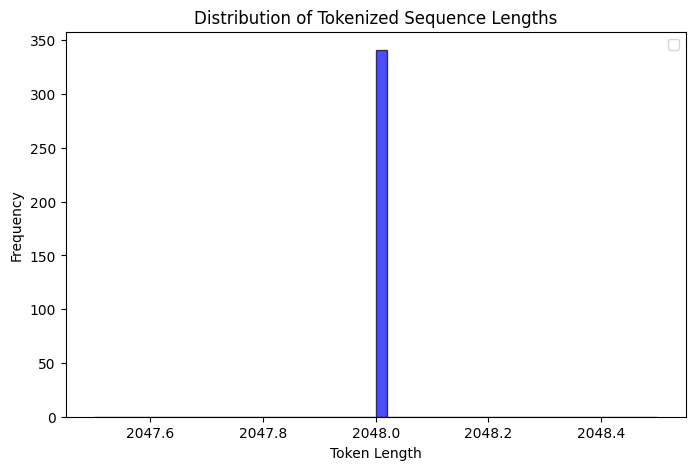

Max Length: 2048 | Min Length: 2048 | Avg Length: 2048.0


In [8]:
# Plot Distribution of Token Lenghts
token_lengths = [len(sample["input_ids"]) for sample in tokenized_dataset_JoStevens]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(token_lengths, bins=50, color="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Tokenized Sequence Lengths")
#plt.axvline(x=4096, color="red", linestyle="dashed", label="Max Length (4096)")
plt.legend()
plt.show()

print(f"Max Length: {max(token_lengths)} | Min Length: {min(token_lengths)} | Avg Length: {sum(token_lengths)/len(token_lengths)}")

# Model Setup

In [9]:
# Optimize Performance with Configurations
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                      # Load model in 4bit, to redeuce memory and computational requirements
    bnb_4bit_use_double_quant=True,         # Double quantization, further compress the model weights
    bnb_4bit_quant_type="nf4",              # Quantization type = nf4
    bnb_4bit_compute_dtype=torch.bfloat16,  # Compute in 16bit format, to speed up computation
)

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto"  # Automatically assigns model to GPU if available
)

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [10]:
# Apply PEFT (Adapter, LoRA and others)
model.gradient_checkpointing_enable()               # Reduce memory usage by saving intermediate activations
model = prepare_model_for_kbit_training(model)      # Prepare model for kbit training to reduce memory usage

## Inspect Model Architecture

The attention mechanism in this model is implemented with **modular projections**, as opposed to a **combined module**: `query_key_value` .
The model uses distinct linear layers for the query (q_proj), key (k_proj), and value (v_proj) projections

In [11]:
# Inspect Model Architecture
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e

# Define LoRA

In [12]:
# Define LoRA configuration
lora_config = LoraConfig(
    r=8,                                  # Rank of the low-rank matrices, lower ranks -> lower computational load & memory usage
    lora_alpha=32,                        # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Specifies the modules that should be adapted using LoRA (*Depends on model architecture)
    lora_dropout=0.1,                     # A Regularization technique used to prevent overfitting
    bias="none",                          # specifies that no additional bias terms should be added
    task_type="CAUSAL_LM"                 # Define the model: one that is 'predicting the next word'
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

In [13]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

print_trainable_parameters(model)

trainable params: 2293760 || all params: 1805757440 || trainable%: 0.12702481236904112


# Define Training Parameters
Define training parameters, including batch size, learning rate, and the number of training epochs.

In [14]:
training_args = TrainingArguments(
    output_dir="outputs",
    optim="paged_adamw_8bit",
    eval_strategy="no",
    #report_to="none",                       # Disable WandB integration
    per_device_train_batch_size=3,          # Adjust the batch size
    gradient_accumulation_steps=4,          # Increaset gradient-steps to reduce memory usage
    warmup_steps=2,                         # Helps to stabilize training
    num_train_epochs=3,                     # Control duration of Training (use either 'max_steps' or 'num_train_epochs')
    learning_rate=2e-5,
    logging_steps=10,                       # Frequency of Training metrics logs for detailed feedback on process
    weight_decay=0.01,

    fp16=True,                              # Enable mixed precision training
    gradient_checkpointing=True,            # Storing only a subset of activations
)

In [15]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args= training_args,                                 # input Training Arguments
    train_dataset= tokenized_dataset_JoStevens,           # input Tokenized Dataset
    data_collator= transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),   # Format batches of data for training
)

# Fine-Tune the Model

In [16]:
# Log in to W&B
import wandb

wandb_api_key = user_secrets.get_secret("wand_API_Key")

wandb.login(key=wandb_api_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: haoting-chan (haoting-chan-gesis). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
# Train the model
model.config.use_cache = False        # disable caching
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250301_014918-53b1jhr8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run outputs
wandb: ⭐️ View project at https://wandb.ai/haoting-chan-gesis/huggingface
wandb: 🚀 View run at https://wandb.ai/haoting-chan-gesis/huggingface/runs/53b1jhr8


Step,Training Loss
10,11.434100
20,11.352900
30,11.345100
40,10.782600
50,10.759900
60,10.759900
70,10.555600
80,10.406900


TrainOutput(global_step=84, training_loss=10.897528966267904, metrics={'train_runtime': 3987.0287, 'train_samples_per_second': 0.257, 'train_steps_per_second': 0.021, 'total_flos': 3.5150263027236864e+16, 'train_loss': 10.897528966267904, 'epoch': 2.982456140350877})

In [18]:
# Save the Fine-Tuned Model
model.save_pretrained("./kaggle/working/fine-tuned-llama_JoStevens")
tokenizer.save_pretrained("./kaggle/working/fine-tuned-llama_JoStevens")

('./kaggle/working/fine-tuned-llama_JoStevens/tokenizer_config.json',
 './kaggle/working/fine-tuned-llama_JoStevens/special_tokens_map.json',
 './kaggle/working/fine-tuned-llama_JoStevens/tokenizer.json')

In [19]:
# Save the fine-tuned model
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:         train/epoch ▁▂▃▄▅▆▇██
wandb:   train/global_step ▁▂▃▄▅▆▇██
wandb:     train/grad_norm ▇█▅▁▅▂▂▆
wandb: train/learning_rate █▇▆▅▄▃▂▁
wandb:          train/loss █▇▇▄▃▃▂▁
wandb: 
wandb: Run summary:
wandb:               total_flos 3.5150263027236864e+16
wandb:              train/epoch 2.98246
wandb:        train/global_step 84
wandb:          train/grad_norm 4.07799
wandb:      train/learning_rate 0.0
wandb:               train/loss 10.4069
wandb:               train_loss 10.89753
wandb:            train_runtime 3987.0287
wandb: train_samples_per_second 0.257
wandb:   train_steps_per_second 0.021
wandb: 
wandb: 🚀 View run outputs at: https://wandb.ai/haoting-chan-gesis/huggingface/runs/53b1jhr8
wandb: ⭐️ View project at: https://wandb.ai/haoting-chan-gesis/huggingface
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Fin